# Load the Housing data set

In [1]:
from my_utilities import loadData as ld
housing = ld.load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
housing.count()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


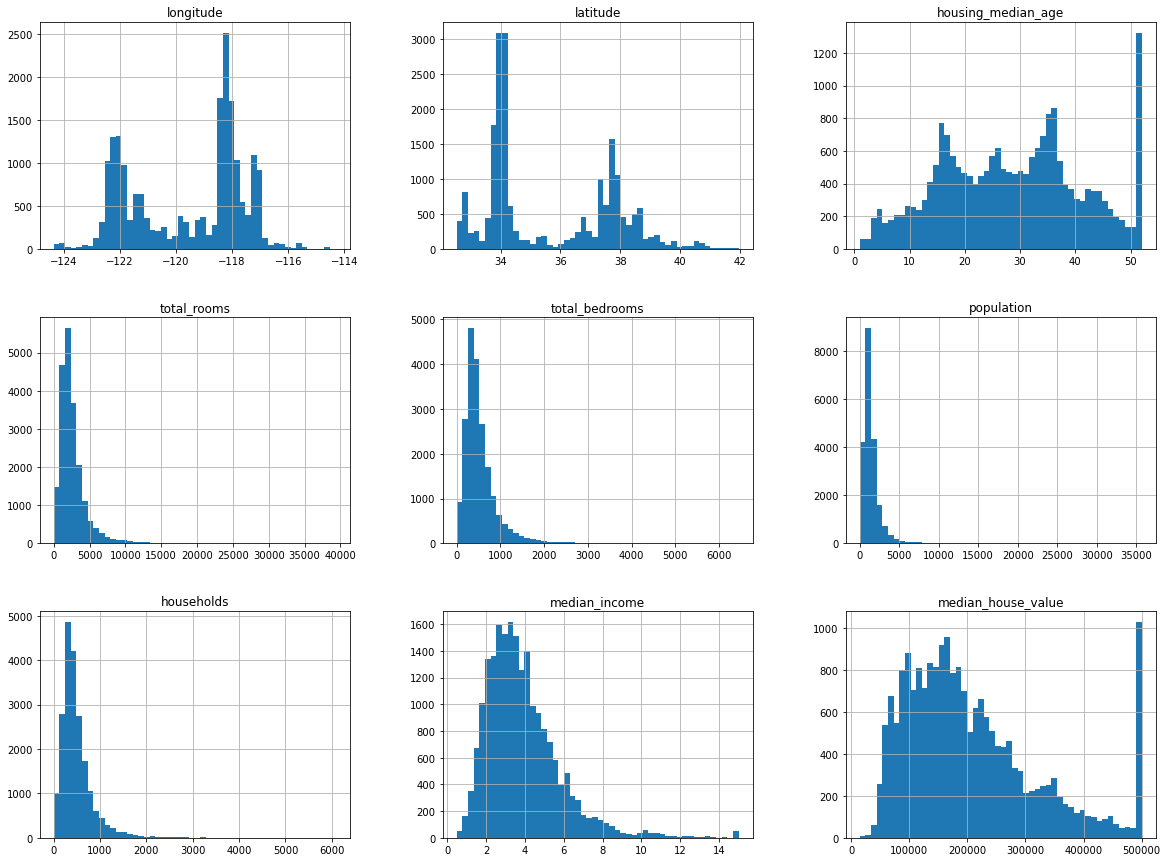

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
housing.hist(bins=50,figsize=(20,15))
#housing["longitude"].hist(bins=50,figsize=(20,15))
plt.show()

# Create a test and train data set split

## Random sampling based on a given test ratio

In [4]:
#Creating a test set. Define a function that takes a dataframe and ratio of test data as inputs and returns the test and train..
#.. data sets
import numpy as np
def split_train_test(data, test_ratio) :
    shuffled_indices = np.random.permutation(len(housing))
    test_set_size = int(len(housing)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]
    
train_set, test_set = split_train_test(housing,0.2)
# Check the length of each set
len(housing),len(train_set),len(test_set)

(20640, 16512, 4128)

In [5]:
# Create a test set split by an ID field. This is to keep the test set unchanged when the dataset is updated by new instances.
# Unlike the previous function this does NOT pick the test data set using randomly selected indices 
import numpy as np
from zlib import crc32
def test_set_check(identifier,test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 **32

def split_train_test_by_id(data,test_ratio,id_column) :
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing,0.2,"id")
# Check the length of each set
len(housing),len(train_set),len(test_set)

(20640, 16322, 4318)

In [6]:
# Create the test and train data set split usng scikit learn based on random selection and a given test_ratio
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(housing, test_size=0.2, random_state=42) # random_state is used for the seed
# Check the length of each set
len(housing),len(train_set),len(test_set)

(20640, 16512, 4128)

## Stratified Sampling

Stratified sampling is used where we need to split the test data set based on a given test ratio but at the same time also respect the profile (distribution / strata) of a feature in the overall dataset. For example, if the distribution of male to female in the overall dataset is 60:40, we need to split the test data set with random samples but still maintain the ratio of male to female the same. This is unlike random sampling where the test data set can end up with any ratio of male to female, although split by the same test ratio  

<AxesSubplot:>

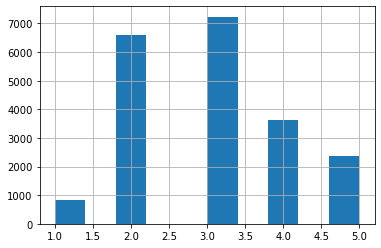

In [7]:
# In this example, we need to perform a stratified sampling of the housing test data by maintaining ...
# ...the same profile for "median_income" feature as in the original dataset
# Step 1 : Derive a new attribute called "income_cat" to create statas of the medium_income feature. 
#          This is because "medium_income"  is qualitative in nature(continuous numerical attribute)
import pandas as pd
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0.0,1.5,3.0,4.5,6.0,np.inf],
                              labels = [1,2,3,4,5])
housing["income_cat"].hist()

In [8]:
# Alternative option to populate the "income_cat" column by iterating through the rows of housing dataframe. 
# This is not a preferred option as it is non performant 
housing["income_cat"] = 0
for index, row in housing.iterrows():
    #print(row["median_income"])    
    if row["median_income"]>= 0.0 and row["median_income"]<= 1.5 :
        housing.loc[index,"income_cat"]= 1
    elif row["median_income"]> 1.5 and row["median_income"]<= 3.0 :
        housing.loc[index,"income_cat"] = 2
    elif row["median_income"]> 3.0 and row["median_income"]<= 4.5 :
        housing.loc[index,"income_cat"] = 3
    elif row["median_income"]> 4.5 and row["median_income"]<= 6.0 :
        housing.loc[index,"income_cat"] = 4
    else :
        housing.loc[index,"income_cat"] = 5
        
housing["income_cat"].value_counts()
           

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [9]:
# Create the test and train data set based on the same profile (distribution) of "income_cat" in the original data set
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Check the length of each set
len(housing),len(train_set),len(test_set)  
    

(20640, 16512, 4128)

(<AxesSubplot:>, <AxesSubplot:>)

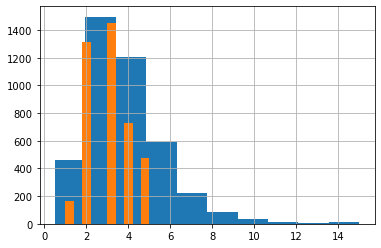

In [10]:
# plot the median_income is the test set to check if we got theh same distribution as the original dataset or not
strat_test_set["median_income"].hist(),strat_test_set["income_cat"].hist()

In [11]:
# Finally, drop the "income_cat" attribute from all datasets
for dataset in (housing,strat_test_set,strat_train_set):
    dataset.drop("income_cat",axis=1,inplace=True)

# Check the final colums
housing.columns,strat_test_set.columns, strat_train_set.columns

(Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity', 'id'],
       dtype='object'),
 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity', 'id'],
       dtype='object'),
 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity', 'id'],
       dtype='object'))

# Data Exploration phase - Visualization and Correlation


In [12]:
# Going forward will only work with the stratified training data set. Hence, create a copy of the data set as "housing"

housing = strat_train_set.copy() # performs a deep copy

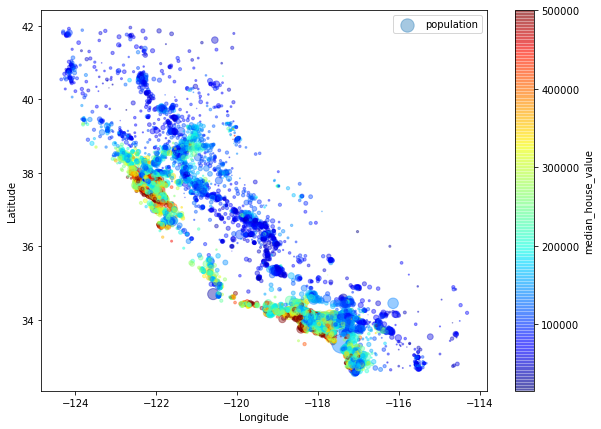

In [13]:
# Visualizing the geographical data i.e. latitude and longitude
from matplotlib import pyplot as plt

fig,ax = plt.subplots() # this is a workaround for an issue of jupyter notebook integration with matplotlib ...
                        #...where the x axis is not visible when color feature is used in the plot.
                        # reference link to the issue and workaround solution - https://github.com/jupyter/notebook/issues/2353

housing.plot(kind = "scatter", 
             c="median_house_value", # color of the scatter points - represents the median_house_value
             x= "longitude", 
             y = "latitude", 
             alpha = 0.4,
             s=housing["population"]/100, # size of the scatter point
             label = "population", # label the feature name that sets the size of the scatter points
             figsize=(10,7), # figsize of the plot             
             cmap =plt.get_cmap("jet"), # color mapping scheme / pallete
             colorbar = True, # displays the colorbar
             ax =ax # part of the workaround solution mentioned above
            )
plt.legend()
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

In [14]:
# Looking for correlations
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,id
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432,1.000000
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724,-0.924323
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110,-0.105947
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097,0.048877
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689,0.076597
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920,0.108014
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506,0.063049
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160,-0.019683
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000,-0.047632
id,1.000000,-0.924323,-0.105947,0.048877,0.076597,0.108014,0.063049,-0.019683,-0.047632,1.000000


In [15]:
#  correlation matrix of all the features with the "median_house_value"
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
id                   -0.047632
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

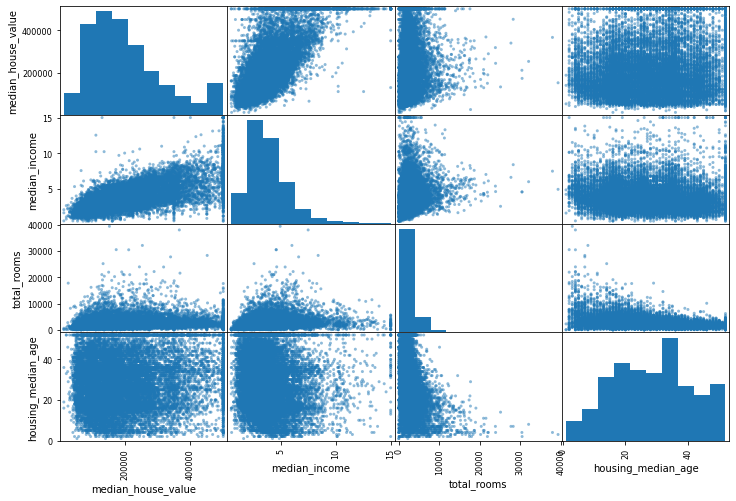

In [16]:
# visualize the correlation using a scatter_matrix
from pandas.plotting import scatter_matrix
# scatter matrix with the top 3 features / attributes that are most correlated with "median_hosue_value"
attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

In [17]:
# Derive additional meaningful attributes and check the correlation matrix again
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

corr_matrix=  housing.corr()

corr_matrix["median_house_value"].sort_values(ascending = False)


median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
id                         -0.047632
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare data for Machine Learning

In [18]:
# Separate the predictors and label (i.e. median_house_value) features into two different data frames
housing = strat_train_set.drop("median_house_value", axis= 1)
housing_labels = strat_train_set["median_house_value"].copy() # deep copy
type(housing_labels)

pandas.core.series.Series

In [19]:
# Create a subset of the predictors dataframe i.e. housing only for the numeric attributes. This is required for data cleaning
housing_num = housing.drop("ocean_proximity",axis=1) # only "ocean_proximity" is the non-numeric attribute in the data set
type(housing_num)

pandas.core.frame.DataFrame

## Data Cleaning

### Imputation of missing numerical values (values = na)

In [20]:
# Using the scikit learn SimpleImputer class to replace the missing values ('na') of numeric attributes with the median value
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")
imputer.fit(housing_num)

# After the fit / training step, we should be able to see the median values of all the numeric attributes
imputer.statistics_
# Now we use the "trained" imputer to transform the training set by replacing the missing values ('na') with the median
X = imputer.transform(housing_num)
X
# the output from imputer.transform is a numpy array of numeric values in the dataframe after imputation
# to display the output in a dataframe format we need do the following
housing_num_tr = pd.DataFrame(X, columns = housing_num.columns,index = housing_num.index)
housing_num_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,id
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,-121852.71
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,-121892.95
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,-117167.23
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,-119573.69
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,-118555.77
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,-118095.80
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,-117526.12
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,-116365.91
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,-117976.18


### Handling Text and Categorical Attributes

In [21]:
housing_cat = pd.DataFrame(housing["ocean_proximity"].copy())
type(housing_cat),housing_cat.shape

(pandas.core.frame.DataFrame, (16512, 1))

In [22]:
# Almost all ML algorithms require categorical aatributes to be represented by numerical values.
# One way is to use OrdinalEncoder class from scikitlearn which assigns numeric values to the distinct categories
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded , ordinal_encoder.categories_

(array([[0.],
        [0.],
        [4.],
        ...,
        [1.],
        [0.],
        [3.]]),
 [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)])

In [23]:
# The issue with OrdinalEncoder is that it assumes the input categories to be ordinal in nature and.... 
# ...therefore generates equivalent numerical values in a ranked alphabetical order.
# This does not work for categories which are actually NOT ordinal in nature. Hence, we need to transform the dataframe...
#...to have separate column for each category and the only possible value being 1 (if the instance belong to the category) or 0.
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # output is a sparse matrix

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [24]:
# display the above output as dense matrix
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [25]:
# cat_encoder categories
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

In [26]:
# Custom transformers help us implement our own custom logic as a class with the fit and transform method. 
# The custom logic can be something like determining derived field values.
# The advantage is that we can integrate custom transformers into the end to end pre-processsing transformation pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room =  True) : # no *args or *kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None) :
        return self # nothing to do in this case
    def transform(self, X):
        rooms_per_household = X[:,rooms_ix] / X[:,households_ix]
        population_per_household = X[:,population_ix] / X[:,households_ix]
        if (self.add_bedrooms_per_room == True):
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]        

In [27]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attributes = attr_adder.transform(housing.values)
housing_extra_attributes

array([[-121.89, 37.29, 38.0, ..., 4.625368731563422, 2.094395280235988,
        0.22385204081632654],
       [-121.93, 37.05, 14.0, ..., 6.008849557522124, 2.7079646017699117,
        0.15905743740795286],
       [-117.2, 32.77, 31.0, ..., 4.225108225108225, 2.0259740259740258,
        0.24129098360655737],
       ...,
       [-116.4, 34.09, 9.0, ..., 6.34640522875817, 2.742483660130719,
        0.1796086508753862],
       [-118.01, 33.82, 31.0, ..., 5.50561797752809, 3.808988764044944,
        0.19387755102040816],
       [-122.45, 37.77, 52.0, ..., 4.843505477308295, 1.9859154929577465,
        0.22035541195476574]], dtype=object)

### Feature Scaling - Normalization & Standardization

In [28]:
# Standardization using sklearn StandardScaler class
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_stdscaled = std_scaler.fit_transform(housing_num)
housing_num_stdscaled

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.42069842,
        -0.61493744, -1.15636   ],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -1.02222705,
         1.33645936, -1.17648178],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.0933178 ,
        -0.5320456 ,  1.18658704],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.71315642,
        -0.3167053 ,  1.58728245],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.37545069,
         0.09812139,  0.78207629],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.3777909 ,
        -0.15779865, -1.43614473]])

### Transformation Pipleines

In [29]:
# pipeline to sequence the transformation steps for the numeric attributes

from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attributes_adder',CombinedAttributesAdder(add_bedrooms_per_room=False)),
    ('std_scaler',StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -1.15636   ,
        -0.31205452, -0.08649871],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -1.17648178,
         0.21768338, -0.03353391],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  1.18658704,
        -0.46531516, -0.09240499],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  1.58728245,
         0.3469342 , -0.03055414],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.78207629,
         0.02499488,  0.06150916],
       [-1.43579109,  0.99645926,  1.85670895, ..., -1.43614473,
        -0.22852947, -0.09586294]])

In [30]:
# Create the full pipleine by combining the numeric and categorical transformation steps
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('num',num_pipeline,num_attribs),
    ('cat',OneHotEncoder(),cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

### Select and Train a Model

In [31]:
# As the problem statement is to predict the median house price, this has to be a regression model. 
# We will start with Linear regression

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [32]:
# As we have trained the model (by calling the fit method), we will compare the predicted values on the training data with ...
# ...the actual labels. The comparison will be done by calculating the "mean squared error" of the output

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse) # root mean square of the error
lin_rmse

68908.2028346915

In [33]:
# Applying DecisionTreeRegressor model and check the rmse
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)

DecisionTreeRegressor()

In [34]:
# Predict using the DecisionTreeRegressor model
housing_predictions = tree_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse) # root mean square of the error
lin_rmse

0.0

In [35]:
# Getting a root mean square error = 0, would probably be a classic example of overfitting.
# So, we need to cross validate this with a validation set, which is again a sunset of the training set.

# The Sci-kit learn's "cross_val_score" class randomly splits the training set into 10 distinct subsets called 'folds'
# Then it trains and models the decision tree model 10 times, by picking a different fold for evaluation each time ...
# ... and training on the other 9 folds. The result is an array containing 10 evaluation scores.

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared,housing_labels,
                        scoring = "neg_mean_squared_error", cv=10)
# -scores
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores,tree_rmse_scores.mean(),tree_rmse_scores.std() 


(array([71167.31759381, 67256.84391337, 68504.05036617, 68440.11562622,
        68712.73301433, 73183.45130013, 69657.50463133, 66856.93664375,
        73965.94362046, 69960.69872264]),
 69770.55954322006,
 2248.333454308179)

In [36]:
# The cross validation method shows that DecisionTreeRegressor model was overfitting and is actually worse than Linear Regression.
# Let's run the cross validation on Linear Regression to confirm

lin_scores = cross_val_score(lin_reg,housing_prepared, housing_labels,
                             scoring = "neg_mean_squared_error", cv=10)
# -scores
lin_rmse_scores = np.sqrt(-lin_scores)
lin_rmse_scores,lin_rmse_scores.mean(),lin_rmse_scores.std() 

(array([67469.33799037, 67258.39556098, 68218.5294979 , 74698.67646904,
        68423.71440328, 71623.99743945, 65189.02740199, 68677.9416759 ,
        72245.91766802, 68119.22850591]),
 69192.47666128428,
 2669.2263016334546)

In [37]:
# Use the 3rd model RandomForestRegressor and see how it performs with cross validations
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse) # root mean square of the error
forest_rmse
# forest_scores = cross_val_score(forest_reg,housing_prepared, housing_labels,
#                              scoring = "neg_mean_squared_error", cv=10)
# forest_rmse_scores = np.sqrt(-forest_scores)
# forest_rmse_scores,forest_rmse_scores.mean(),forest_rmse_scores.std() 

18726.397828616235

In [42]:
# Saiving the 3 models

import joblib

joblib.dump(lin_reg, "models/lin_reg.pkl")
joblib.dump(tree_reg, "models/tree_reg.pkl")
joblib.dump(forest_reg, "models/forest_reg.pkl")

['models/forest_reg.pkl']

### Fine Tune the Model 
#### This process involves tuning the hyperparameters of a model to derive the best prediction outcomes

In [43]:
# We will use the SciKitLearn's GridSearchCV model to get the best hyperparameter combination. 
# We will apply this on the RandomForestRegressor model
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}
]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg,param_grid,cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score = True)
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [44]:
# Getting the best estimator directly
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [81]:
# Get the evaluation scores for each combination
scores = grid_search.cv_results_
# for mean_score,params in zip(scores["mean_test_score"],scores["params"]):
#     print(np.sqrt(-mean_score),params)
list(zip(np.sqrt(-scores["mean_test_score"]),scores["params"]))    

[(60352.19665477883, {'max_features': 2, 'n_estimators': 3}),
 (52872.33116265932, {'max_features': 2, 'n_estimators': 10}),
 (50617.12577914694, {'max_features': 2, 'n_estimators': 30}),
 (56682.55885648089, {'max_features': 4, 'n_estimators': 3}),
 (50711.3551167211, {'max_features': 4, 'n_estimators': 10}),
 (48231.73990971511, {'max_features': 4, 'n_estimators': 30}),
 (56654.03365874169, {'max_features': 6, 'n_estimators': 3}),
 (50276.00201472575, {'max_features': 6, 'n_estimators': 10}),
 (48081.733784645505, {'max_features': 6, 'n_estimators': 30}),
 (56560.19147305437, {'max_features': 8, 'n_estimators': 3}),
 (50055.494710079154, {'max_features': 8, 'n_estimators': 10}),
 (48459.26371941478, {'max_features': 8, 'n_estimators': 30}),
 (60688.19872218367,
  {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}),
 (51560.204194625156,
  {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}),
 (56703.854293775046,
  {'bootstrap': False, 'max_features': 3, 'n_estimators

In [46]:
# Implement RandomizedSearchCV module

### Analyse the best models and feature importances

In [47]:
# Using the feature_importances function to get the array of relative feature importances in the dataset
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([5.07526993e-02, 7.16721094e-02, 3.92693374e-02, 1.83997325e-02,
       1.60451605e-02, 1.78989159e-02, 1.57152316e-02, 3.17850614e-01,
       6.99490594e-02, 9.61665438e-02, 1.00995559e-01, 1.32132191e-02,
       1.56980845e-01, 4.82430416e-05, 7.32218795e-03, 7.72054172e-03])

In [77]:
# Create a list of all feature names and display the importance values next to them
derived_attribs =['rooms_per_hhold','pop_per_hhold','bedrooms_per_room']
cat_encoder= full_pipeline.named_transformers_["cat"] # get the encoder used for preparing the categorical attributes
cat_one_hot_attribs= list(cat_encoder.categories_[0])
attributes = num_attribs + derived_attribs + cat_one_hot_attribs
#attributes
#sorted(zip(feature_importances,attributes),reverse = True)
list(zip(feature_importances,attributes))

[(0.05075269932363238, 'longitude'),
 (0.07167210936405448, 'latitude'),
 (0.03926933741426472, 'housing_median_age'),
 (0.018399732485345942, 'total_rooms'),
 (0.016045160533752753, 'total_bedrooms'),
 (0.017898915857396676, 'population'),
 (0.015715231604233312, 'households'),
 (0.31785061395279346, 'median_income'),
 (0.06994905937942424, 'id'),
 (0.09616654380598262, 'rooms_per_hhold'),
 (0.10099555931615448, 'pop_per_hhold'),
 (0.013213219139320359, 'bedrooms_per_room'),
 (0.15698084511894406, '<1H OCEAN'),
 (4.824304163191832e-05, 'INLAND'),
 (0.007322187946687394, 'ISLAND'),
 (0.00772054171638127, 'NEAR BAY')]

### Evaluate the system on the Test Set

In [86]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value",axis=1)
Y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(final_predictions,Y_test)
final_rmse = np.sqrt(final_mse).round(2)
final_rmse

46532.63

In [88]:
# Compute the 95% Confidence Interval of the generalization error
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - Y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) -1, loc = squared_errors.mean(), scale = stats.sem(squared_errors)))


array([44562.55088145, 48422.62316609])